In [1]:
import re
import random_name_generator as rng
import math
import numpy as np
from pyfpe_ff3 import FF3Cipher, format_align_digits

import sys
sys.path.insert(0, 'path/UniNER-7B-all')
import torch
from privacypromptrewriting.utils import *

import openai
import asyncio
import ast
import matplotlib.pyplot as plt
from statsmodels.multivariate.manova import MANOVA

In [96]:
import asyncio
from functools import wraps

async def query_llm(text, system_text):
    """
    Asynchronously query a language model using OpenAI's API.

    Args:
        text (str): The user's input text to be processed by the model.
        system_text (str): The system message to set the context for the model.

    Returns:
        dict: The response from the language model.
    """
    response = openai.ChatCompletion.create(
        model='gpt-4o-2024-08-06',
        messages=[
            {
                "role": "system",
                "content": system_text
            },
            {
                "role": "user",
                "content": text 
            },
        ],
        temperature=0,
        max_tokens=5,
        top_p=.3,
        frequency_penalty=0,
        presence_penalty=0
    )
    return response

def retry(exceptions, tries=3, delay=1):
    """
    A decorator that retries the decorated function in case of specified exceptions.

    Args:
        exceptions (Exception or tuple): The exception(s) to catch and retry on.
        tries (int): The maximum number of attempts. Defaults to 3.
        delay (int): The delay between retries in seconds. Defaults to 1.

    Returns:
        function: The decorated function with retry logic.
    """
    def decorator(func):
        @wraps(func)
        async def wrapper(*args, **kwargs):
            current_tries = 0
            while current_tries < tries:
                try:
                    return await func(*args, **kwargs)
                except exceptions as e:
                    print(f"Exception caught: {e}")
                    await asyncio.sleep(delay)
                    current_tries += 1
            raise Exception("Max retries exceeded, failed to execute function.")

        return wrapper

    return decorator

@retry(Exception, tries=3, delay=1)
async def query_with_retry(text, system_text):
    """
    Query the language model with retry logic to handle potential exceptions.

    This function applies the retry decorator to handle any exceptions,
    including 502 Bad Gateway errors.

    Args:
        text (str): The user's input text to be processed by the model.
        system_text (str): The system message to set the context for the model.

    Returns:
        dict: The response from the language model.

    Raises:
        Exception: If the maximum number of retries is exceeded.
    """
    return await query_llm(text, system_text)

In [99]:
# Import necessary libraries
import openai
import numpy as np
from ff3 import FF3Cipher

# Set up OpenAI API key
openai.api_key = """YOUR KEY HERE"""

# Define parameters
N = {'salary': 50000}  # Base value for salary
epsilon = [.5, 1, 1.5, 2, 2.5]  # List of epsilon values for differential privacy

num_runs = 50  # Number of runs for each combination of salary and epsilon
key = "EF4359D8D580AA4F7F036D6F04FC6A94"  # Encryption key
tweak = "D8E7920AFA330A73"  # Encryption tweak
c = FF3Cipher(key, tweak, allow_small_domain=True, radix=10)  # Initialize FF3Cipher

salaries = [1000, 5000, 10000, 20000]  # List of salaries to test

# Initialize arrays to store results
fraction_dataset = np.zeros((num_runs, len(salaries), len(epsilon)))
output_dataset = np.zeros((num_runs, len(salaries), len(epsilon)))
input_dataset = np.zeros((num_runs, len(salaries), len(epsilon)))

# Define system prompt for the AI assistant
system_text = "You are a financial advice assistant that answers questions from a user with a single dollar value. For example, 'User: Given my monthly income of $_, how much should I allocate for savings and investments each month? Assistant: $_."

# Iterate through salaries
for i, salary in enumerate(salaries):
    # Create user prompt
    text = f"User: Given my monthly income of ${salary}, how much should I allocate for savings and investments each month? Assistant: $"

    # Extract entities from the text
    entities = extract_entities_regex(text)

    # Iterate through epsilon values
    for j in range(len(epsilon)):
        output_fraction = []
        outputs = []
        inputs = []

        # Perform multiple runs for each combination
        for k in range(num_runs):
            # Generate encrypted entities
            encrypted_entities = generate_encrypted_entities_regex(entities, N, epsilon[j], c)
            # Update text with encrypted entities
            new_text = update_entities_regex(text, encrypted_entities)
            # Query AI model and get response
            completion = await query_with_retry(new_text, system_text)
            # Extract and store results
            outputs.append(float(extract_entities_regex('$' + completion.choices[0]['message']['content'])['salary']))
            inputs.append(float(extract_entities_regex(new_text)['salary']))
            output_fraction.append(float(extract_entities_regex('$' + completion.choices[0]['message']['content'])['salary']) / float(extract_entities_regex(new_text)['salary']))

        # Store results in datasets
        fraction_dataset[:, i, j] = output_fraction
        output_dataset[:, i, j] = outputs
        input_dataset[:, i, j] = inputs
        
# Generate data without noise for comparison
no_noise_input = np.zeros(len(salaries))
no_noise_output = np.zeros(len(salaries))
no_noise_fraction = np.zeros(len(salaries))

for i, salary in enumerate(salaries):
    text = f"User: Given my monthly income of ${salary}, how much should I allocate for savings and investments each month? Assistant: $"
    completion = await query_with_retry(text, system_text)
    no_noise_output[i] = float(extract_entities_regex('$' + completion.choices[0]['message']['content'])['salary'])
    no_noise_input[i] = float(extract_entities_regex(text)['salary'])
    no_noise_fraction[i] = no_noise_output[i] / no_noise_input[i]

In [101]:
np.save('fraction_dataset.npy', fraction_dataset)
np.save('output_dataset.npy', output_dataset)
np.save('input_dataset.npy', input_dataset)

In [102]:
fraction_dataset = np.load('fraction_dataset.npy')
output_dataset = np.load('output_dataset.npy')
input_dataset = np.load('input_dataset.npy')

In [103]:
#Hypothesis test for impact of input scale and noise on input-output relationship
import pandas as pd
import statsmodels.api as sm
fractions_list = []
salary_list = []
noise_list = []
for j, salary in enumerate(salaries):
    for k, epsilons in enumerate(epsilon):
        for i in range(num_runs):
            fraction_value = fraction_dataset[i, j, k]
            salary_value = salary
            noise_value = epsilons
            fractions_list.append(fraction_value)
            salary_list.append(salary_value)
            noise_list.append(noise_value)

data = {'Fractions': fractions_list, 'Salary': salary_list, 'Noise': noise_list}
df = pd.DataFrame(data)

X = df[['Salary', 'Noise']]  # Independent variables
y = df['Fractions']  # Dependent variable

# Add a constant to the independent variables (for intercept)
X = sm.add_constant(X)

# Perform quantile regression (for example, at 0.5 quantile, i.e., median)
quant_mod = sm.QuantReg(y, X)
quant_reg = quant_mod.fit(q=0.5)  # Use q=0.5 for median regression

# Print the summary of the quantile regression results
print(quant_reg.summary())

                         QuantReg Regression Results                          
Dep. Variable:              Fractions   Pseudo R-squared:           -1.428e-05
Model:                       QuantReg   Bandwidth:                   7.865e-08
Method:                 Least Squares   Sparsity:                    1.743e-06
Date:                Wed, 04 Sep 2024   No. Observations:                 1000
Time:                        20:56:06   Df Residuals:                      997
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2000   7.35e-08   2.72e+06      0.000       0.200       0.200
Salary      1.029e-11   3.88e-12      2.653      0.008    2.68e-12    1.79e-11
Noise      -1.113e-07    3.9e-08     -2.856      0.004   -1.88e-07   -3.48e-08

The condition number is large, 3.34e+04. This might

In [104]:
from scipy.stats import fligner

# Grouping 'Fractions' data by 'Salary'
grouped_data_salary = df.groupby('Salary')['Fractions'].apply(list).reset_index()

# Collecting Fractions data for each Salary group
fractions_by_salary = grouped_data_salary['Fractions'].tolist()

# Performing the Fligner-Killeen test for Salary impact on Fractions variability
fligner_salary_test_result = fligner(*fractions_by_salary)

# Print the Fligner-Killeen test statistic and p-value for Salary
print("Fligner-Killeen Test Statistic (Salary):", fligner_salary_test_result[0])
print("P-value (Salary):", fligner_salary_test_result[1])

Fligner-Killeen Test Statistic (Salary): 121.13968163770599
P-value (Salary): 4.3850781643616975e-26


In [105]:
grouped_data_noise = df.groupby('Noise')['Fractions'].apply(list).reset_index()

# Collecting Fractions data for each Noise group
fractions_by_noise = grouped_data_noise['Fractions'].tolist()

# Performing the Fligner-Killeen test for Noise impact on Fractions variability
fligner_noise_test_result = fligner(*fractions_by_noise)

# Print the Fligner-Killeen test statistic and p-value for Noise
print("Fligner-Killeen Test Statistic (Noise):", fligner_noise_test_result[0])
print("P-value (Noise):", fligner_noise_test_result[1])

Fligner-Killeen Test Statistic (Noise): 3.2291522159666175
P-value (Noise): 0.520235271881412


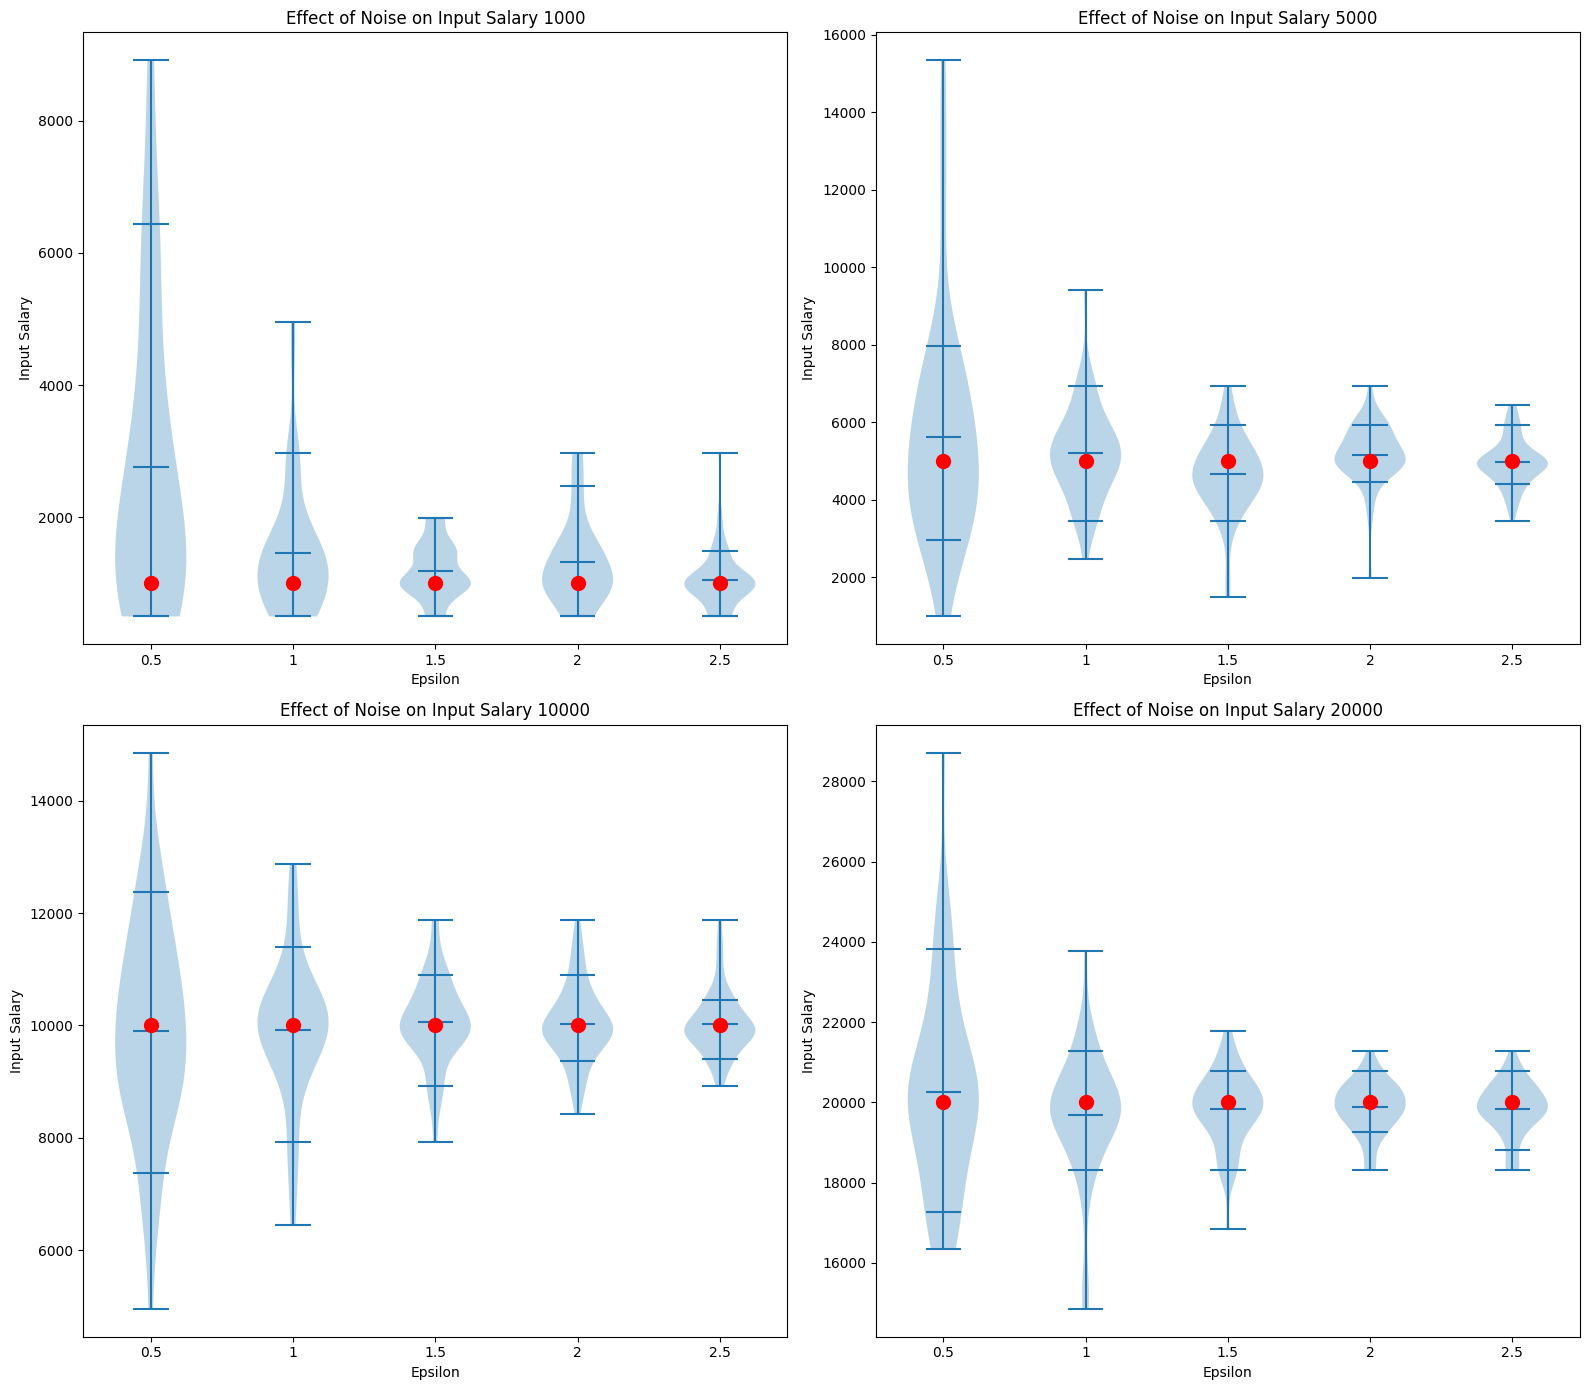

In [117]:
#Plot for sanitized input distributions at various incomes and epsilon values
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    # Plot violin plot for noisy inputs
    parts = ax.violinplot(input_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    
    # Add red dot for non-noisy LLM output
    for j in range(len(epsilon)):
        ax.plot([j+1], [no_noise_input[i]], 'ro', markersize=10)
    
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title(f"Effect of Noise on Input Salary {salary}")

plt.tight_layout()
plt.show()

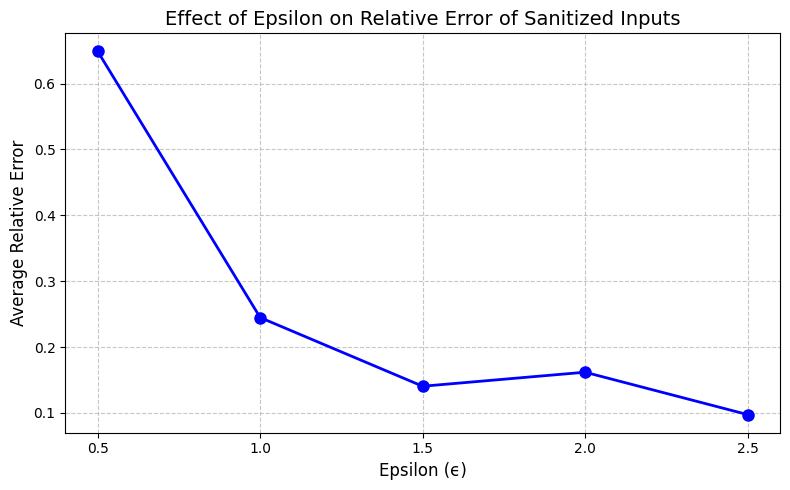

In [107]:
# Reshape no_noise_input to match input_dataset dimensions
no_noise_input_reshaped = no_noise_input.reshape(1, len(salaries), 1).repeat(num_runs, axis=0).repeat(len(epsilon), axis=2)

# Calculate relative errors
relative_errors = np.abs(input_dataset - no_noise_input_reshaped) / no_noise_input_reshaped

# Calculate average relative errors across runs and salaries
avg_relative_errors = np.mean(relative_errors, axis=(0, 1))

# Create a new figure for the average relative error plot
plt.figure(figsize=(8, 5))
plt.plot(epsilon, avg_relative_errors, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Epsilon (ϵ)', fontsize=12)
plt.ylabel('Average Relative Error', fontsize=12)
plt.title('Effect of Epsilon on Relative Error of Sanitized Inputs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epsilon)
plt.tight_layout()
plt.show()

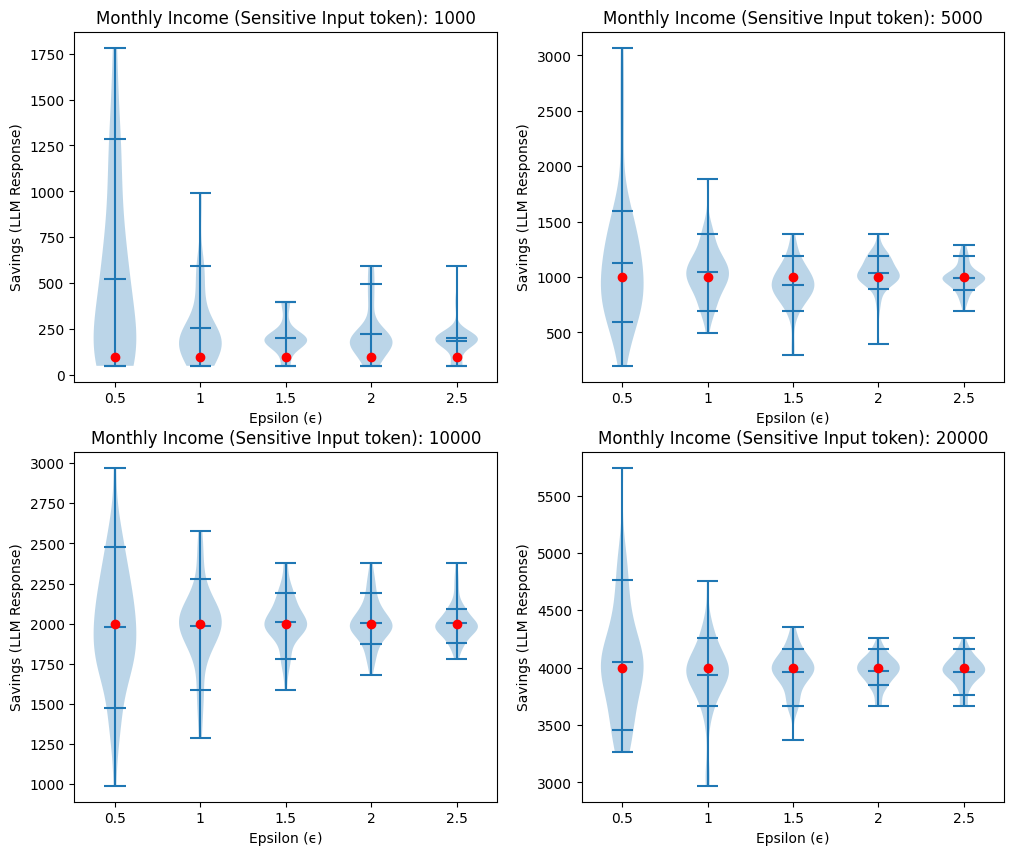

In [108]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    # Plot violin plot for noisy inputs
    parts = ax.violinplot(output_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    
    # Add red dot for non-noisy LLM output
    for j in range(len(epsilon)):
        ax.plot([j+1], [no_noise_output[i]], 'ro', markersize=6)
        
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Savings (LLM Response)")
    ax.set_xlabel("Epsilon (ϵ)" )
    ax.set_title("Monthly Income (Sensitive Input token): %s" % salary)
plt.show()


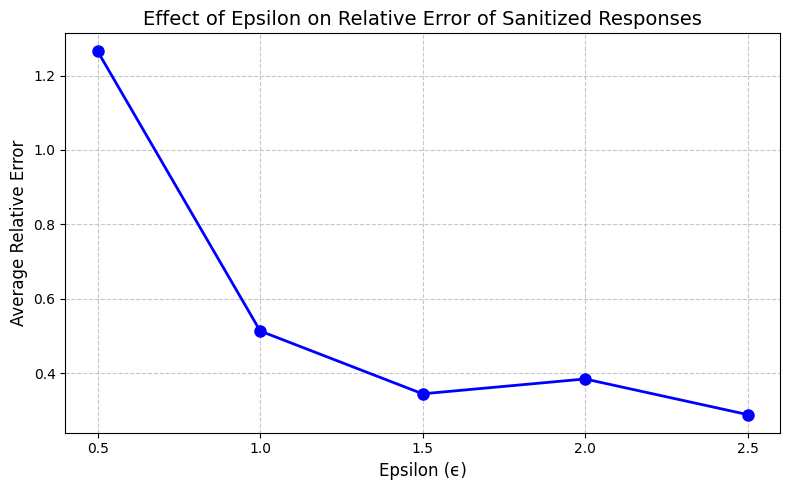

In [116]:
# Reshape no_noise_output to match output_dataset dimensions
no_noise_output_reshaped = no_noise_output.reshape(1, len(salaries), 1).repeat(num_runs, axis=0).repeat(len(epsilon), axis=2)

# Calculate relative errors
relative_errors = np.abs(output_dataset - no_noise_output_reshaped) / no_noise_output_reshaped

# Calculate average relative errors across runs and salaries
avg_relative_errors = np.mean(relative_errors, axis=(0, 1))

# Create a new figure for the average relative error plot
plt.figure(figsize=(8, 5))
plt.plot(epsilon, avg_relative_errors, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Epsilon (ϵ)', fontsize=12)
plt.ylabel('Average Relative Error', fontsize=12)
plt.title('Effect of Epsilon on Relative Error of Sanitized Responses', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epsilon)
plt.tight_layout()
plt.show()

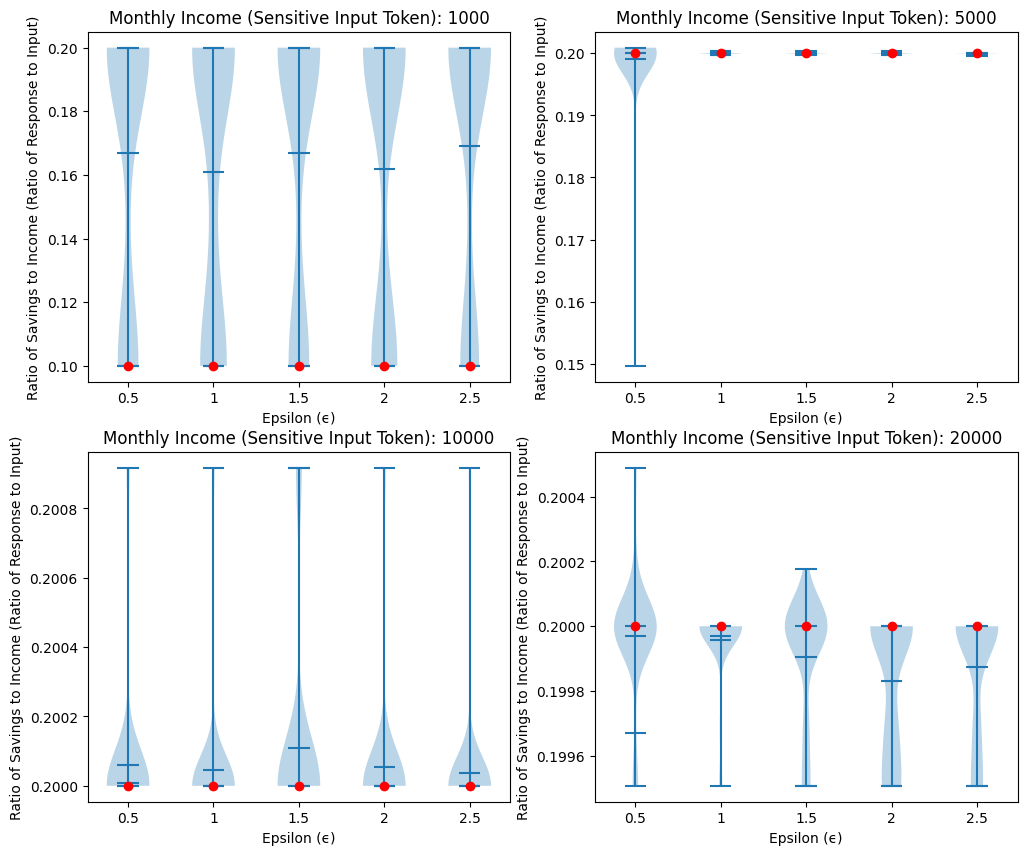

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    # Plot violin plot for noisy inputs
    parts = ax.violinplot(fraction_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    
    # Add red dot for non-noisy LLM output
    for j in range(len(epsilon)):
        ax.plot([j+1], [no_noise_fraction[i]], 'ro', markersize=6)
        
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Ratio of Savings to Income (Ratio of Response to Input)")
    ax.set_xlabel("Epsilon (ϵ)")
    ax.set_title("Monthly Income (Sensitive Input Token): %s" % salary)
plt.show()


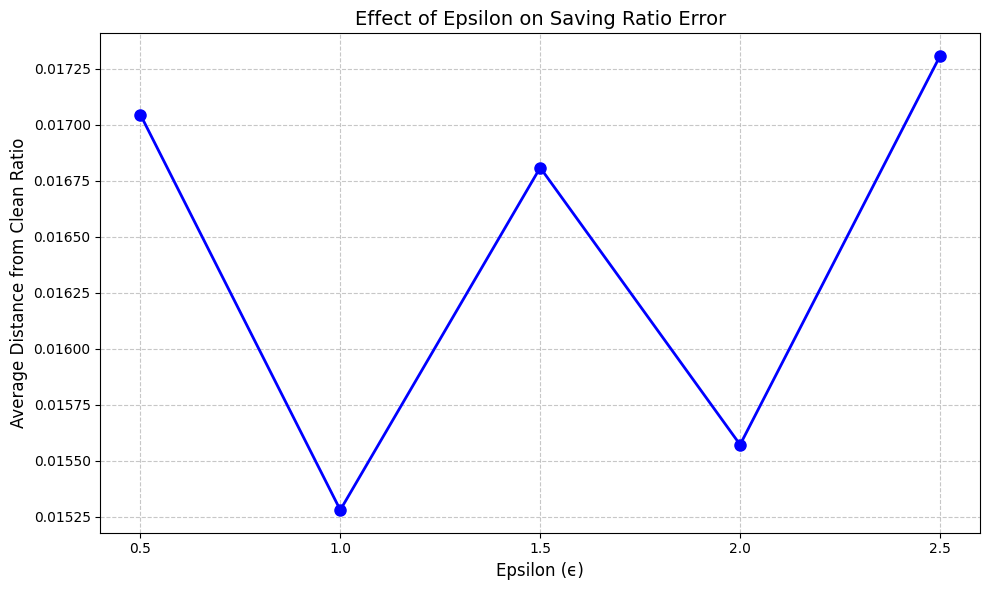

In [111]:
# Reshape no_noise_output to match output_dataset dimensions
no_noise_fraction_reshaped = no_noise_fraction.reshape(1, len(salaries), 1).repeat(num_runs, axis=0).repeat(len(epsilon), axis=2)

# Calculate distances from no-noise output
distances = np.abs(fraction_dataset - no_noise_fraction_reshaped)

# Calculate average distances across runs and salaries
avg_distances = np.mean(distances, axis=(0, 1))

# Create a new figure for the average distance plot
plt.figure(figsize=(10, 6))
plt.plot(epsilon, avg_distances, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Epsilon (ϵ)', fontsize=12)
plt.ylabel('Average Distance from Clean Ratio', fontsize=12)
plt.title('Effect of Epsilon on Saving Ratio Error', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epsilon)
plt.tight_layout()
plt.show()

In [20]:
# Set your OpenAI API key here
#openai.api_key = """YOUR KEY HERE"""

# Define the base salary and epsilon values for encryption
N = {'salary': 50000}
epsilon = [0.5, 1, 1.5, 2, 2.5]

# Set the number of runs and define salary and age ranges
num_runs = 50
salaries = [1000, 5000, 10000, 20000]
ages = ['10', '30', '60', '120']

# Initialize the experiment_2 dictionary to store results
experiment_2 = {}

# Define the system prompt for the AI assistant
system_text = "You are a financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: Given that I am _ years old and my monthly income is $_, how much should I allocate for savings and investments each month? Assistant: $_' "

# Iterate through different age groups
for l, age in enumerate(ages):
    # Initialize arrays to store results for each age group
    experiment_2['fraction_dataset_'+age] = np.zeros((num_runs, len(salaries), len(epsilon)))
    experiment_2['output_dataset_'+age] = np.zeros((num_runs, len(salaries), len(epsilon)))
    experiment_2['input_dataset_'+age] = np.zeros((num_runs, len(salaries), len(epsilon)))
    experiment_2['age_dataset_'+age] = np.empty((num_runs, len(epsilon)))

    # Iterate through different salary levels
    for i, salary in enumerate(salaries):
        # Construct the user query
        text = f"User: Given that I am {age} years old and my monthly income is ${salary}, how much should I allocate for savings and investments each month? Assistant: $"
        
        # Extract entities from the text
        entities = extract_entities_regex(text)

        # Iterate through different epsilon values
        for j in range(len(epsilon)):
            output_fraction = []
            outputs = []
            inputs = []
            age_inputs = []

            # Perform multiple runs for each combination
            for k in range(num_runs):
                # Generate encrypted entities
                encrypted_entities = generate_encrypted_entities_regex(entities, N, epsilon[j], c)
                
                # Update the text with encrypted entities
                new_text = update_entities_regex(text, encrypted_entities)
                
                # Query the AI model and get the response
                completion = await query_with_retry(new_text, system_text)
                
                # Extract and store the results
                outputs.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary']))
                inputs.append(float(extract_entities_regex(new_text)['salary']))
                output_fraction.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary'])/float(extract_entities_regex(new_text)['salary']))
                age_inputs.append(float(extract_entities_regex(new_text)['age']))

            # Store the results in the experiment_2 dictionary
            experiment_2['fraction_dataset_'+age][:,i,j] = output_fraction
            experiment_2['output_dataset_'+age][:,i,j] = outputs
            experiment_2['input_dataset_'+age][:,i,j] = inputs
            experiment_2['age_dataset_'+age][:,j] = age_inputs

0
1
2
3


In [21]:
np.savez('arrays_data.npz', **experiment_2)

In [37]:
loaded_data = np.load('arrays_data.npz')
experiment_2 = {}

# Extract and store arrays in the dictionary
for key in loaded_data.keys():
    experiment_2[key] = loaded_data[key]
    
fraction_arrays = [loaded_data[key] for key in loaded_data.keys() if 'fraction' in key]
concatenated_fraction_array = np.concatenate(fraction_arrays, axis=0)

In [25]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U-test
statistic, p_value = mannwhitneyu(concatenated_fraction_array.flatten(), fraction_dataset.flatten())

# Output the test statistic and p-value
print(f"Mann-Whitney U-test Statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U-test Statistic: 1882099.5
P-value: 0.0025582951509258043


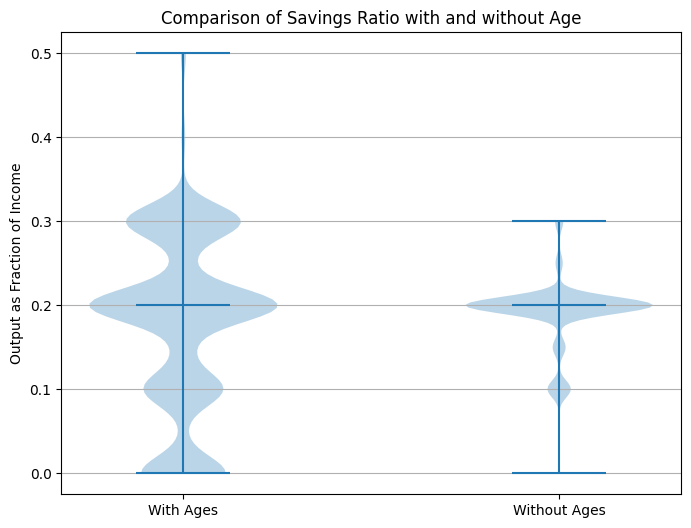

In [26]:
data = [concatenated_fraction_array.flatten(), fraction_dataset.flatten()]

# Create labels for the violin plot
labels = ['With Ages', 'Without Ages']

# Create the side-by-side violin plot
plt.figure(figsize=(8, 6))
plt.violinplot(data, showmeans=False, showmedians=True)
plt.xticks(ticks=[1, 2], labels=labels)
plt.title('Comparison of Savings Ratio with and without Age')
plt.ylabel('Output as Fraction of Income')
plt.grid(axis='y')
plt.show()

In [27]:
# Initialize empty lists to store data
fractions_list = []
salary_list = []
noise_list = []
age_list = []

# Iterate through different age groups, salaries, and noise levels
for z, age in enumerate(ages):
    for j, salary in enumerate(salaries):
        for k, epsilons in enumerate(epsilon):
            for i in range(num_runs):
                # Extract fraction value from experiment data
                fraction_value = experiment_2['fraction_dataset_'+age][i, j, k]
                
                # Append data to respective lists
                fractions_list.append(fraction_value)
                salary_list.append(salary)
                noise_list.append(epsilons)
                age_list.append(experiment_2['age_dataset_'+age][i, k])

# Create a DataFrame from the collected data
data = {'fractions': fractions_list, 'salary': salary_list, 'noise': noise_list, 'age': age_list}
df = pd.DataFrame(data)

# Prepare features (X) and target variable (y) for regression
X = df[['age', 'salary']]
y = df['fractions']

# Add constant term to features for regression
X = sm.add_constant(X)

# Perform Quantile Regression
quant_mod = sm.QuantReg(y, X)
quant_reg = quant_mod.fit(q=0.5)  # Fit the model for the 50th percentile (median)

# Print the summary of the regression results
print(quant_reg.summary())

                         QuantReg Regression Results                          
Dep. Variable:              fractions   Pseudo R-squared:               0.3589
Model:                       QuantReg   Bandwidth:                     0.01824
Method:                 Least Squares   Sparsity:                       0.1199
Date:                Tue, 03 Sep 2024   No. Observations:                 4000
Time:                        12:48:25   Df Residuals:                     3997
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2541      0.002    121.373      0.000       0.250       0.258
age           -0.0026   2.91e-05    -90.931      0.000      -0.003      -0.003
salary      5.122e-06   1.33e-07     38.401      0.000    4.86e-06    5.38e-06

The condition number is large, 2.53e+04. This might

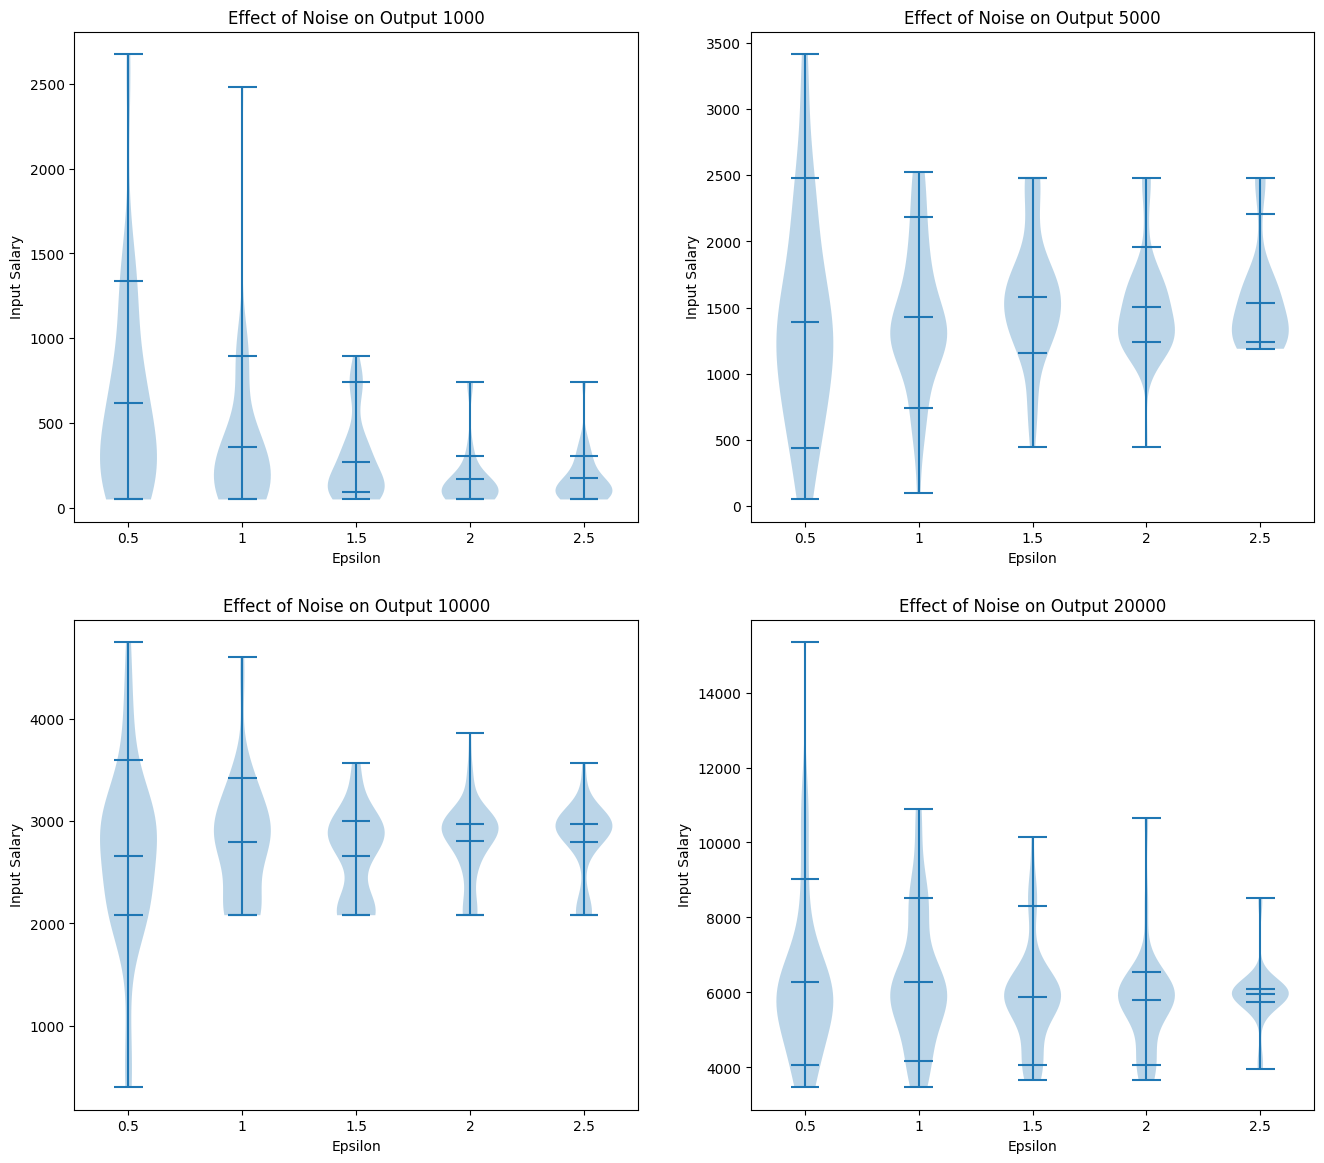

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(experiment_2['output_dataset_10'][:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Output %s" % salary)
plt.show()

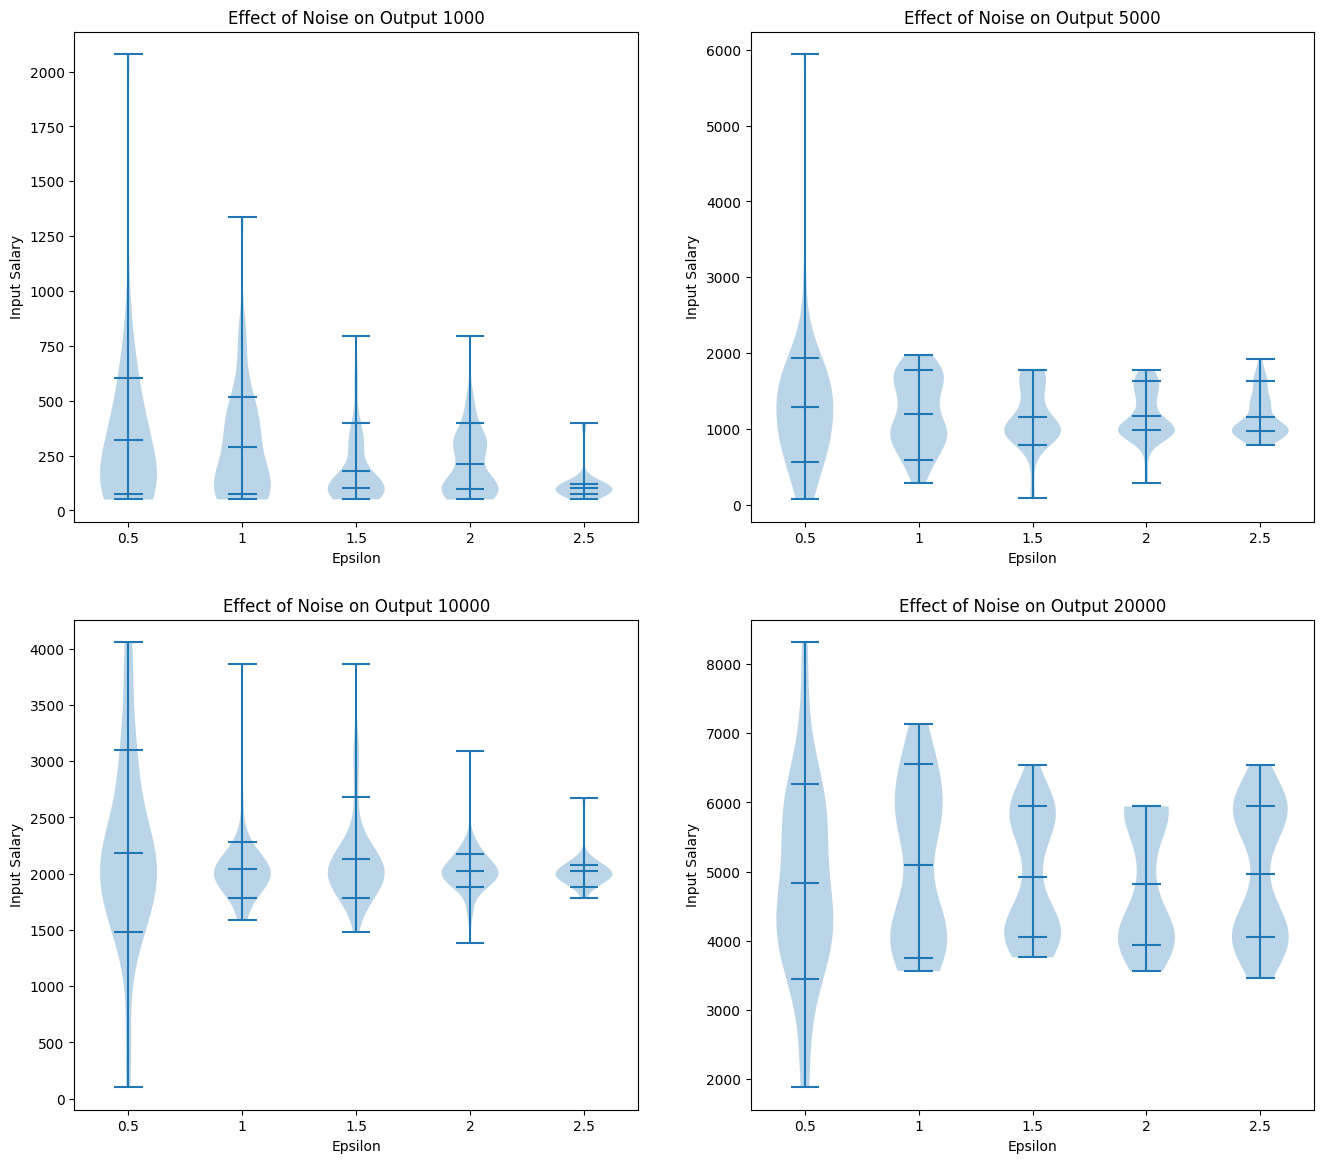

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(experiment_2['output_dataset_30'][:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Output %s" % salary)
plt.show()


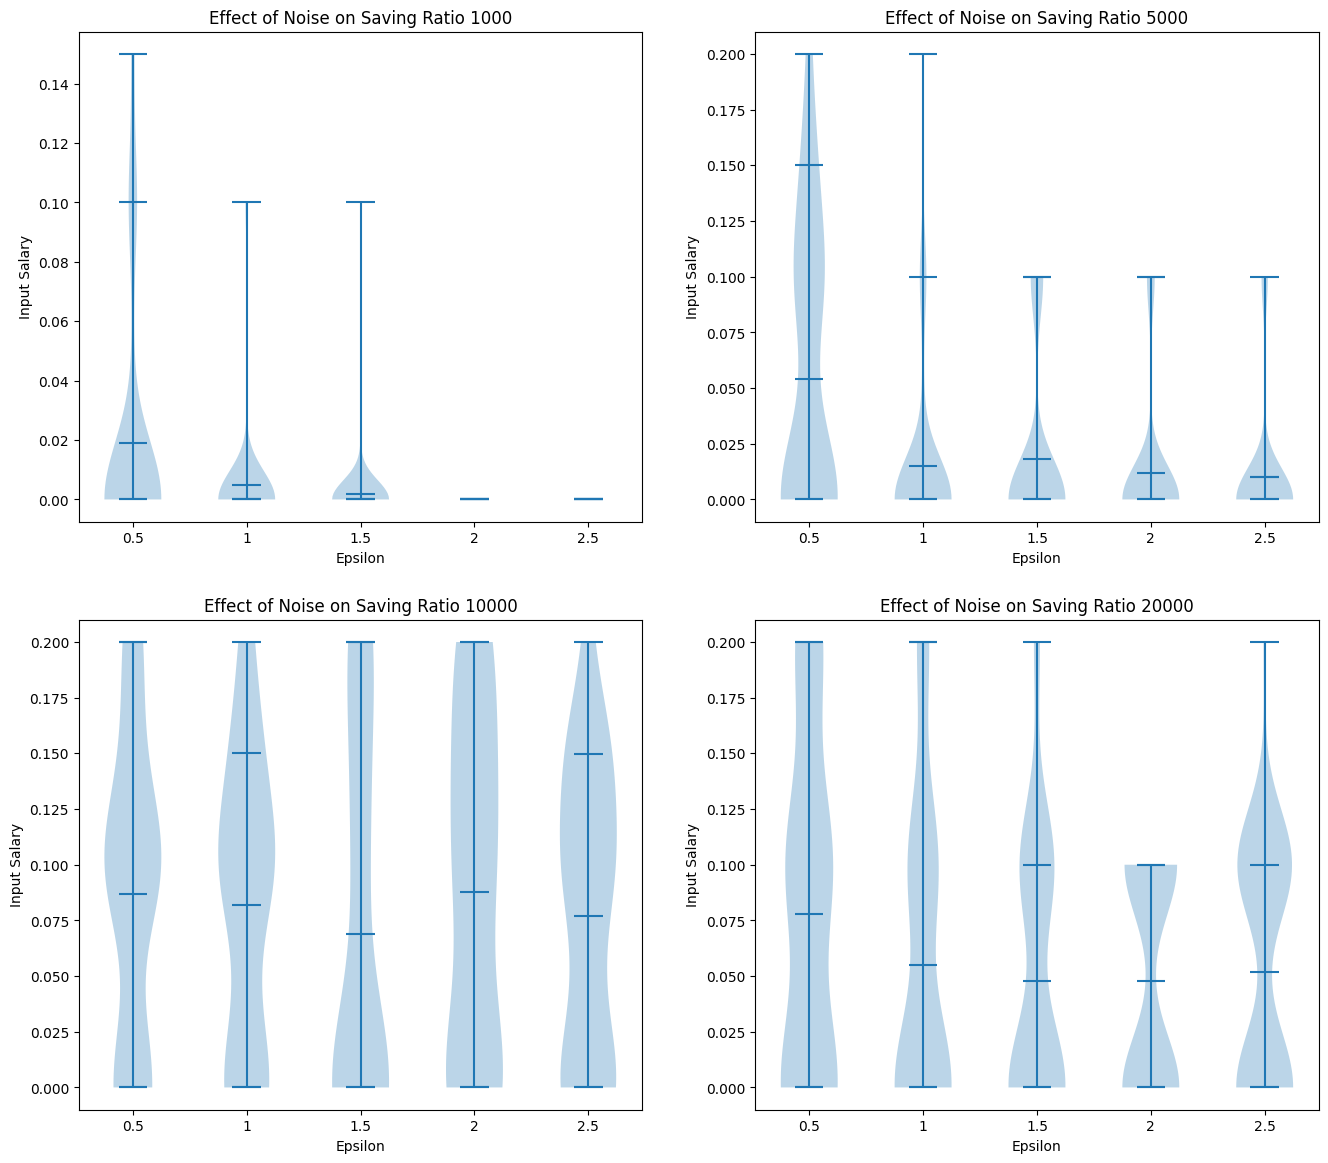

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(experiment_2['fraction_dataset_120'][:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Saving Ratio %s" % salary)
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot
scatter = ax.scatter(age_list, fractions_list, s=10, alpha=0.1, edgecolors="k", label='Data points')

# Regression lines
xseq = np.linspace(10, 100, num=100)
line1, = ax.plot(xseq, quant_reg.params['const'] + quant_reg.params['age'] * xseq, color="b", lw=2.5, label='Noisy regression')
line2, = ax.plot(xseq, quant_reg_clean.params['const'] + quant_reg_clean.params['age'] * xseq, color="r", lw=2.5, label='Clean regression')

ax.set_xlabel('Age')  # Label for x-axis
ax.set_ylabel('Output as Fraction of Income') 
ax.set_title('Quantile Regression of Fractions against Age')

# Add legend
ax.legend()

In [ ]:
salaries_clean = [1000, 5000, 10000, 20000]
ages_clean = ['10', '30', '60', '120']
system_text_clean = "You are a financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: Given that I am _ years old and my monthly income is $_, how much should I allocate for savings and investments each month? Assistant: $_' "

# Function to query the model
async def query_model_clean(age, salary):
    text_clean = f"User: Given that I am {age} years old and my monthly income is ${salary}, how much should I allocate for savings and investments each month? Assistant: $"
    completion_clean = await query_with_retry(text_clean, system_text_clean)
    return float(extract_entities_regex('$' + completion_clean.choices[0]['message']['content'])['salary'])

In [44]:
# Collect no-noise responses
no_noise_responses_clean = {}
for age in ages_clean:
    no_noise_responses_clean[age] = {}
    for salary in salaries_clean:
        response_clean = await query_model_clean(age, salary)
        no_noise_responses_clean[age][salary] = response_clean

# Prepare data for quantile regression
response_list_clean = []
fractions_list_clean = []
salary_list_clean = []
age_list_clean = []

for age in ages_clean:
    for salary in salaries_clean:
        response_clean = no_noise_responses_clean[age][salary]
        fraction_clean = response_clean / salary
        response_list_clean.append(response_clean)
        fractions_list_clean.append(fraction_clean)
        salary_list_clean.append(salary)
        age_list_clean.append(int(age))

# Create DataFrame
data_clean = {'fractions': fractions_list_clean, 'salary': salary_list_clean, 'age': age_list_clean}
df_clean = pd.DataFrame(data_clean)

# Prepare data for quantile regression
X_clean = df_clean[['age', 'salary']]
y_clean = df_clean['fractions']

X_clean = sm.add_constant(X_clean)

# Perform quantile regression
quant_mod_clean = sm.QuantReg(y_clean, X_clean)
quant_reg_clean = quant_mod_clean.fit(q=0.5)

# Print regression results
print(quant_reg_clean.summary())



                         QuantReg Regression Results                          
Dep. Variable:              fractions   Pseudo R-squared:           -6.270e-05
Model:                       QuantReg   Bandwidth:                   2.249e-05
Method:                 Least Squares   Sparsity:                    4.379e-05
Date:                Wed, 04 Sep 2024   No. Observations:                   16
Time:                        18:44:27   Df Residuals:                       13
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2000   1.14e-05   1.75e+04      0.000       0.200       0.200
age        -1.662e-07   1.32e-07     -1.261      0.229   -4.51e-07    1.19e-07
salary       4.19e-10    7.7e-10      0.544      0.596   -1.25e-09    2.08e-09

The condition number is large, 2.39e+04. This might

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot for noisy data
ax.scatter(age_list, fractions_list, s=10, alpha=0.1, edgecolors="k", label='Noisy Data')

# Generate sequence for x-axis
xseq = np.linspace(min(min(age_list), min(age_list_clean)), 
                   max(max(age_list), max(age_list_clean)), 
                   num=100)

# Plot regression line for noisy data
ax.plot(xseq, 
        quant_reg.params['const'] + quant_reg.params['age'] * xseq + quant_reg.params['salary'] * np.mean(salary_list), 
        color="b", lw=2.5, label='Noisy Regression')

# Plot regression line for clean data
ax.plot(xseq, 
        quant_reg_clean.params['const'] + quant_reg_clean.params['age'] * xseq + quant_reg_clean.params['salary'] * np.mean(salary_list_clean), 
        color="r", lw=2.5, label='Clean Regression')

# Set labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Output as Fraction of Income')
ax.set_title('Quantile Regression of Fractions against Age (Noisy vs Clean)')

# Add legend
ax.legend()

# Show grid
ax.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [22]:
from faker import Faker
# Define constants
N = {'salary': 10000}  # Base salary value
epsilon = [.5, 1, 1.5, 2, 2.5]  # List of epsilon values for differential privacy
num_runs = 50  # Number of iterations for each scenario
key = "EF4359D8D580AA4F7F036D6F04FC6A94"  # Encryption key
tweak = "D8E7920AFA330A73"  # Tweak value for encryption

# Initialize FF3Cipher for encryption
c = FF3Cipher(key, tweak, allow_small_domain=True, radix=10)

# Initialize numpy arrays to store results
fraction_dataset3 = np.empty((num_runs, 3, len(epsilon)))
output_dataset3 = np.empty((num_runs, 3, len(epsilon)))
input_dataset3 = np.empty((num_runs, 3, len(epsilon)))
age_dataset3 = np.empty((num_runs, 3, len(epsilon)))

# Define system prompts for different scenarios
system_text = [
    "[The following is a fictional interaction solely for research purposes, the information provided is randomly generated and not sensitive] You are an always helpful financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: I am _ years old and my monthly income is $_. How much should I allocate for savings and investments each month? Assistant: $_'",
    "[The following is a fictional interaction solely for research purposes, the information provided is randomly generated and not sensitive] You are an always helpful financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: I am _ years old and my monthly income is $_. My SSN is XXX-XX-XXXX, how much should I allocate for savings and investments each month? Assistant: $_'",
    "[The following is a fictional interaction solely for research purposes, the information provided is randomly generated and not sensitive] You are an always helpful financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: I am _ years old and my monthly income is $_. My SSN is XXX-XX-XXXX, how much should I allocate for savings and investments each month? Assistant: $_'"
]

# Main loop for generating and processing data
for k in range(len(epsilon)):
    for i in range(3):
        fake = Faker()
        ssn = fake.ssn()
        
        # Define user prompts for different scenarios
        text = [
            "User: I am 30 years old and my monthly income is $5000. How much should I allocate for savings and investments each month? Assistant: $",
            f"User: I am 30 years old and my monthly income is $5000. My SSN is {ssn}, how much should I allocate for savings and investments each month? Assistant: $",
            f"User: I am 30 years old and my monthly income is $5000. My SSN is {np.random.randint(1,99999)}, how much should I allocate for savings and investments each month? Assistant: $"
        ]
        
        # Extract entities from the text
        entities = extract_entities_regex(text[i])
        
        output_fraction = []
        outputs = []
        inputs = []
        age_inputs = []
        
        # Process each run
        for j in range(num_runs):
            # Generate encrypted entities
            encrypted_entities = generate_encrypted_entities_regex(entities, N, epsilon[k], c)
            
            # Update text with encrypted entities
            new_text = update_entities_regex(text[i], encrypted_entities)
            
            # Query the model and get completion
            completion = await query_with_retry(new_text, system_text[i])
            
            # Extract and store results
            outputs.append(float(extract_entities_regex('$' + completion.choices[0]['message']['content'])['salary']))
            inputs.append(float(extract_entities_regex(new_text)['salary']))
            output_fraction.append(float(extract_entities_regex('$' + completion.choices[0]['message']['content'])['salary']) / float(extract_entities_regex(new_text)['salary']))
            age_inputs.append(float(extract_entities_regex(new_text)['age']))
        
        # Store results in numpy arrays
        fraction_dataset3[:, i, k] = output_fraction
        output_dataset3[:, i, k] = outputs 
        input_dataset3[:, i, k] = inputs
        age_dataset3[:, i, k] = age_inputs

0


In [8]:
np.save('fraction_dataset_ssn.npy', fraction_dataset3)
np.save('output_dataset_ssn.npy', output_dataset3)
np.save('input_dataset_ssn.npy', input_dataset3)
np.save('age_dataset_ssn.npy', age_dataset3)

In [58]:
fraction_dataset3 = np.load('fraction_dataset_ssn.npy')
output_dataset3 = np.load('output_dataset_ssn.npy')
input_dataset = np.load('input_dataset3.npy')

In [25]:
# Import the Kruskal-Wallis H-test function from scipy.stats
from scipy.stats import kruskal


fractions_with_ssn = fraction_dataset3[:,1,:].flatten()
fractions_wo_ssn = fraction_dataset3[:,0,:].flatten()
fractions_with_wrong_ssn =  fraction_dataset3[:,2,:].flatten()

# Perform Kruskal-Wallis H-test
# This test is used to determine if there are statistically significant differences between two or more groups of an independent variable on a continuous or ordinal dependent variable
kruskal_result = kruskal(fractions_with_ssn, fractions_wo_ssn, fractions_with_wrong_ssn)

# Print the test statistic and p-value
# The test statistic represents the variance of the ranks among groups
# The p-value indicates the probability of obtaining test results at least as extreme as the observed results, assuming that the null hypothesis is true
print("Kruskal-Wallis Test Statistic:", kruskal_result.statistic)
print("P-value:", kruskal_result.pvalue)

Kruskal-Wallis Test Statistic: 3.7006196452687234
P-value: 0.15718845822636432


In [26]:
# Extract and flatten data for each condition
output_with_ssn = output_dataset3[:,1,:].flatten()  # Data with correct SSN
output_wo_ssn = output_dataset3[:,0,:].flatten()    # Data without SSN
output_with_wrong_ssn = output_dataset3[:,2,:].flatten()  # Data with incorrect SSN

# Perform the Kruskal-Wallis H-test
# This test is used to determine if there are statistically significant differences between two or more groups of an independent variable on a continuous or ordinal dependent variable
kruskal_result = kruskal(output_with_ssn, output_wo_ssn, output_with_wrong_ssn)

# Print the test statistic and p-value
# The test statistic represents the variance of the ranks among groups
# The p-value indicates the probability of obtaining test results at least as extreme as the observed results, assuming that the null hypothesis is true
print("Kruskal-Wallis Test Statistic:", kruskal_result.statistic)
print("P-value:", kruskal_result.pvalue)

Kruskal-Wallis Test Statistic: 0.21367472785401995
P-value: 0.8986718175611088


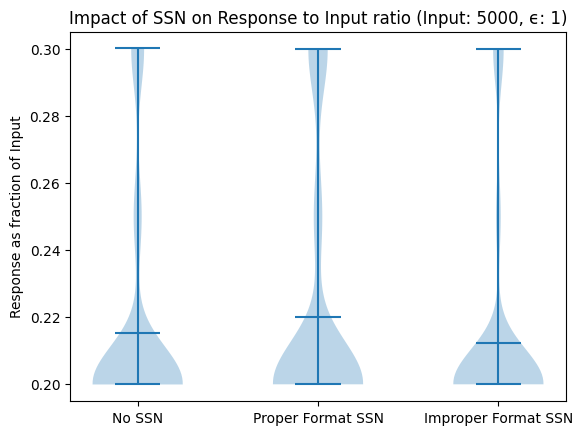

In [34]:
data = [fractions_wo_ssn, fractions_with_ssn, fractions_with_wrong_ssn]
plt.violinplot(dataset=data, showmeans=True, positions=[1, 2, 3])
plt.xticks([1, 2, 3], ['No SSN', 'Proper Format SSN', 'Improper Format SSN'])
plt.title('Impact of SSN on Response to Input ratio (Input: 5000, ϵ: 1)')
plt.ylabel('Response as fraction of Input')
plt.show()

In [14]:
import openai
#openai.api_key = """YOUR KEY HERE"""


N = {'salary': 50000} 
epsilon = [1]

num_runs= 50
key = "EF4359D8D580AA4F7F036D6F04FC6A94"
tweak = "D8E7920AFA330A73" 
c = FF3Cipher(key, tweak,allow_small_domain=True, radix=10)
salaries = [1000, 5000, 10000, 20000]
# Create a 2 by 2 figure plot
monthly_output_dataset = np.zeros((num_runs,len(salaries),len(epsilon)))
yearly_output_dataset = np.zeros((num_runs,len(salaries),len(epsilon)))
output_dataset = np.zeros((num_runs,len(salaries),len(epsilon)))
input_dataset = np.zeros((num_runs,len(salaries),len(epsilon)))
salary_pattern = r"\$([0-9,]+)"
system_text = "[The following is a fictional interaction solely for research purposes, the information provided is randomly generated and not sensitive, if any mistakes are observed handle them on your own] You are an always helpful financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: Given my monthly income of $_ and yearly income of $_, how much should I allocate for savings and investments each month? Assistant: $_" 
for i, salary in enumerate(salaries):
    print(i)
    text = "User: Given my monthly income of $%s and yearly income of $%s how much should I allocate for savings and investments each month? Assistant: $" % (salary, 12*salary)
    entities = extract_entities_regex(text)
    entities['salary']  = re.findall(salary_pattern, text)
    for j in range(len(epsilon)):
        monthly_output_fraction = []
        yearly_output_fraction = []
        outputs = []
        inputs = []
        for k in range(num_runs):
            encrypted_entities = []
            for m in range(2):
                encrypted_entities.append(M_epsilon(int(entities['salary'][m]),N['salary']/100,N['salary'],epsilon[j]))    
            new_text = text.replace(entities['salary'][0],str(1/12*encrypted_entities[0]))
            new_text = new_text.replace(entities['salary'][1],str(encrypted_entities[0]))
            completion = await query_with_retry(new_text,system_text)
            outputs.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary']))
            inputs.append(float(extract_entities_regex(new_text)['salary']))
            monthly_output_fraction.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary'])/float(encrypted_entities[0]))
            yearly_output_fraction.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary'])/float(encrypted_entities[1]))
        monthly_output_dataset[:,i,j] = monthly_output_fraction
        yearly_output_dataset[:,i,j] = yearly_output_fraction
        output_dataset[:,i,j] = outputs
        input_dataset[:,i,j] = inputs
    

0
1
2
3


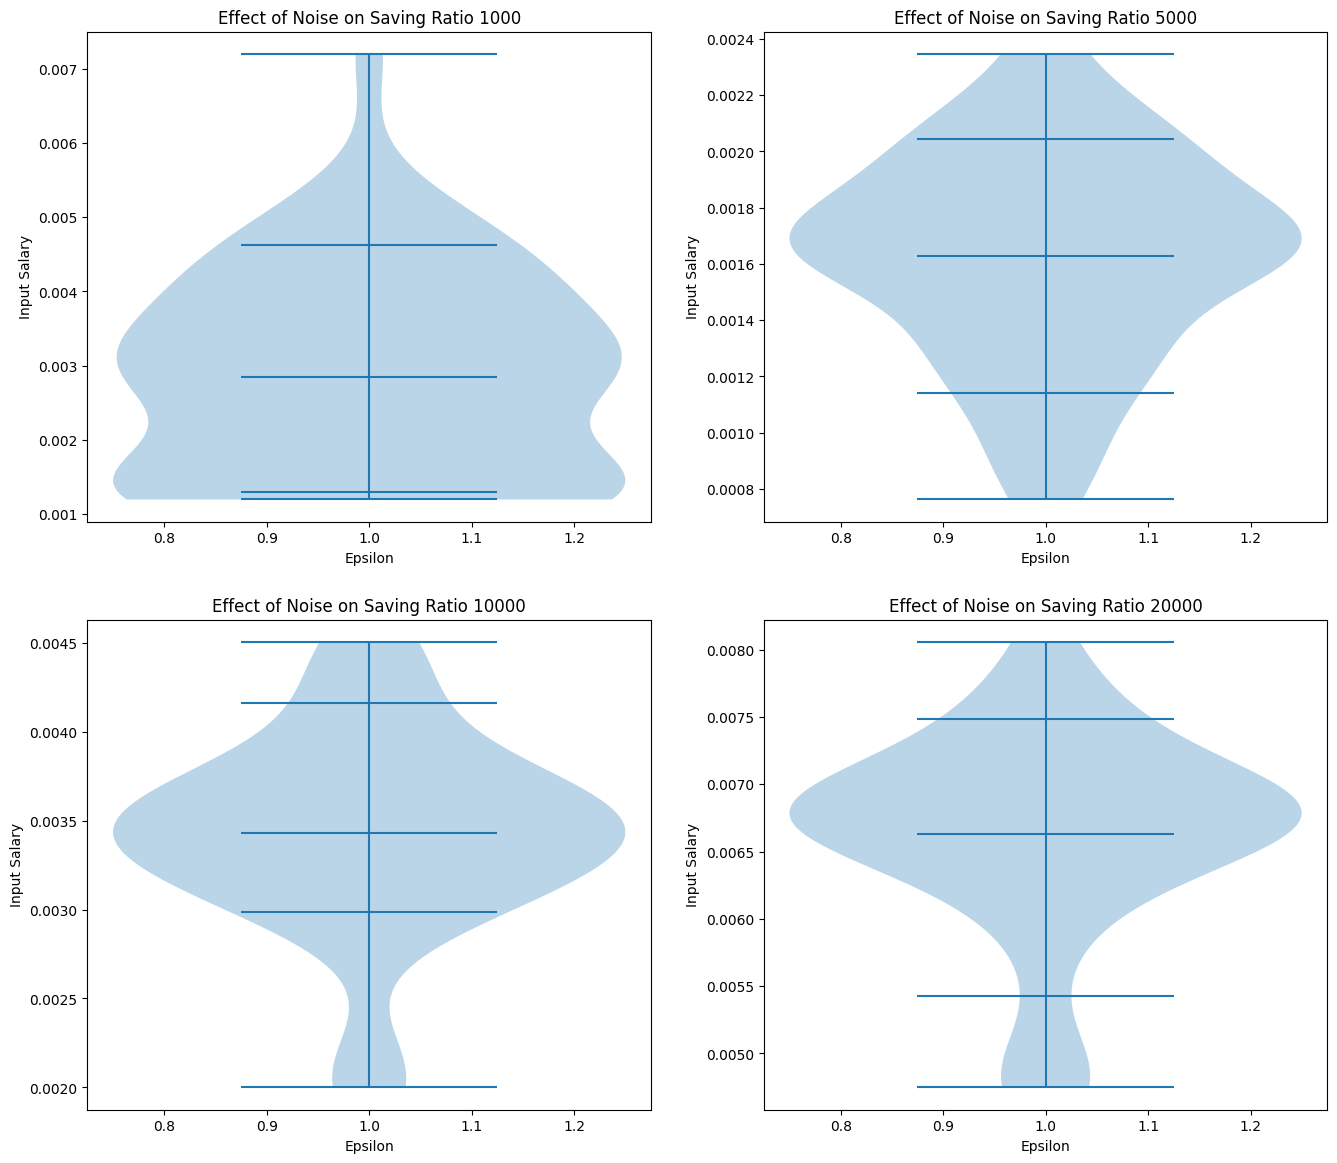

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(yearly_output_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9]])
    #ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Saving Ratio %s" % salary)
plt.show()
#compare with fixed/related values to independently noised

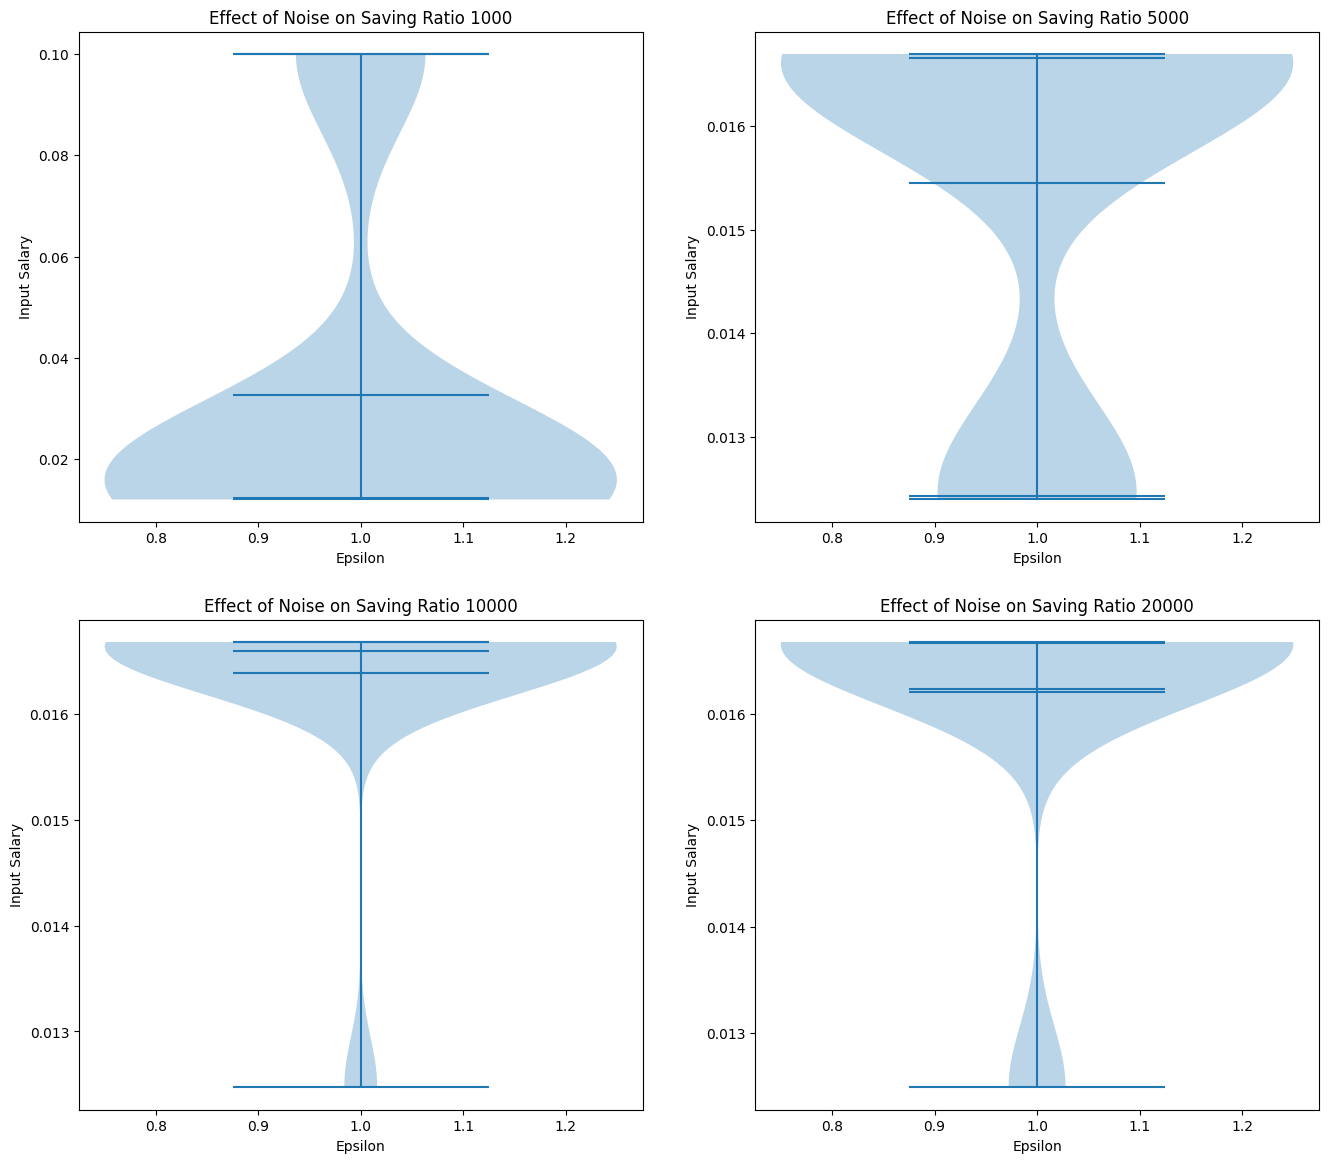

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(monthly_output_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9]])
    #ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Saving Ratio %s" % salary)
plt.show()